In [156]:
import os
import random 
import numpy 
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Load dataset 

In [130]:
train_dir = r'..\Data\Training'
test_dir = r'..\Data\Testing'

train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

for i in range(5):
    k = random.randint(0,len(train_labels)-1)
    print('Train dataset:',train_paths[k],'-->', train_labels[k])

test_paths = []
test_labels  =[]

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)
test_paths, test_labels = shuffle(test_paths, test_labels)

for i in range(5):
    k = random.randint(0,len(test_labels)-1)
    print('Test dataset:', test_paths[k],'-->', test_labels[k])

print(f'train samples: {len(train_paths)} \n'
      f'test samples: {len(test_paths)} \n'
      f'Ratio (test/total): {len(test_paths)/(len(train_paths)+len(test_paths))}')

Train dataset: ..\Data\Training\pituitary\Tr-pi_1328.jpg --> pituitary
Train dataset: ..\Data\Training\pituitary\Tr-pi_0407.jpg --> pituitary
Train dataset: ..\Data\Training\notumor\Tr-no_0023.jpg --> notumor
Train dataset: ..\Data\Training\glioma\Tr-gl_1100.jpg --> glioma
Train dataset: ..\Data\Training\meningioma\Tr-me_0484.jpg --> meningioma
Test dataset: ..\Data\Testing\pituitary\Te-pi_0059.jpg --> pituitary
Test dataset: ..\Data\Testing\meningioma\Te-me_0059.jpg --> meningioma
Test dataset: ..\Data\Testing\glioma\Te-gl_0117.jpg --> glioma
Test dataset: ..\Data\Testing\notumor\Te-no_0350.jpg --> notumor
Test dataset: ..\Data\Testing\notumor\Te-no_0020.jpg --> notumor
train samples: 5712 
test samples: 1311 
Ratio (test/total): 0.18667236223835967


# Data visualization

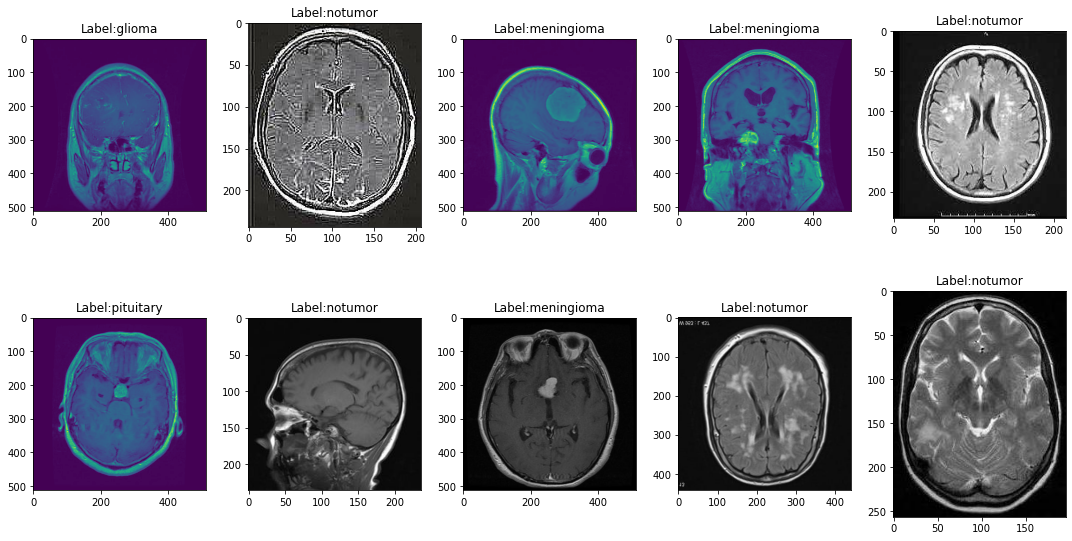

In [131]:

Rsamples = random.sample(range(len(train_labels)),10)

fig, axes = plt.subplots(2,5, figsize= (15,8))
axes = axes.ravel() # to fatten the 3D images for displaying
# fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i, idx in enumerate(Rsamples):
    img = Image.open(train_paths[idx])
    #img.show()
    plt.figure()
    axes[i].imshow(img)
    axes[i].set_title('Label:'+train_labels[idx])
    plt.close() # hides the intermediated message from image plotter.
plt.tight_layout()
plt.show()
plt.close()


# Image preprocessing

In [132]:
# image augmentation 
def augment(image):
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.3,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.3,1.2))
    image = numpy.array(image)/ 255.0 # normalize to [0,1]
    return numpy.array(image)

# Encoding labels to integers
def encode_labels(label_text):
    if label_text == 'glioma':
        label = 0
    elif label_text == 'meningioma':
        label = 1
    elif label_text == 'notumor':
        label = 2
    elif label_text == 'pituitary':
        label = 3
    else:
        print(' \n Label is out of range \n')
    return label

# preprcessing
def data_preprocess(img_paths, labels, IMAGE_SIZE):
    processed_imgs= []
    processed_labels = []
    for i in range(len(img_paths)):
        img = load_img(img_paths[i], target_size=(IMAGE_SIZE, IMAGE_SIZE))
        processed_img = augment(img)
        processed_imgs.append(processed_img)
        processed_labels.append(encode_labels(labels[i]))  # text to integer

    return numpy.array(processed_imgs), numpy.array(processed_labels)


In [133]:
IMAGE_SIZE = 128
# print([train_labels[x] for x in range(0,5)])
# print([test_labels[x] for x in range(0,5)])
train_data, train_int_labels = data_preprocess(train_paths, train_labels, IMAGE_SIZE)
test_data, test_int_labels = data_preprocess(test_paths, test_labels, IMAGE_SIZE)

['meningioma', 'pituitary', 'notumor', 'glioma', 'notumor']
['notumor', 'glioma', 'pituitary', 'meningioma', 'notumor']


In [134]:
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (5712, 128, 128, 3)
Test data shape: (1311, 128, 128, 3)


# Model Architecture

In [135]:
# parameters 
lr = 1e-4
batch_size = 16
epochs = 10

# model
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top= False, weights='imagenet')
#freeze most layers of the model
layers = base_model.layers
for i in range(len(layers)-4):  # Make last three layers trainable
    layers[i].trainable = False

# Build the architecture
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(len(os.listdir(train_dir)), activation= 'softmax'))

# compile the model
model.compile(
    optimizer = Adam(learning_rate=lr),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
    )
# model configuration 
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_8 (Dropout)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [136]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# fit the model
history = model.fit(
    train_data, 
    train_int_labels,
    epochs= epochs,
    batch_size= batch_size,
    validation_data = (test_data,test_int_labels), 
    callbacks = [early_stop]
)

Epoch 1/10
357/357 [==============================] - 407s 1s/step - loss: 0.6197 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.4753 - val_sparse_categorical_accuracy: 0.8192
Epoch 2/10
357/357 [==============================] - 392s 1s/step - loss: 0.3455 - sparse_categorical_accuracy: 0.8668 - val_loss: 0.3473 - val_sparse_categorical_accuracy: 0.8589
Epoch 3/10
357/357 [==============================] - 372s 1s/step - loss: 0.2707 - sparse_categorical_accuracy: 0.8967 - val_loss: 0.2983 - val_sparse_categorical_accuracy: 0.8902
Epoch 4/10
357/357 [==============================] - 368s 1s/step - loss: 0.2029 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.2524 - val_sparse_categorical_accuracy: 0.8947
Epoch 5/10
357/357 [==============================] - 367s 1s/step - loss: 0.1572 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.1999 - val_sparse_categorical_accuracy: 0.9191
Epoch 6/10
357/357 [==============================] - 367s 1s/step - loss: 0.1420 - sparse_cate

# Train and validation history plots

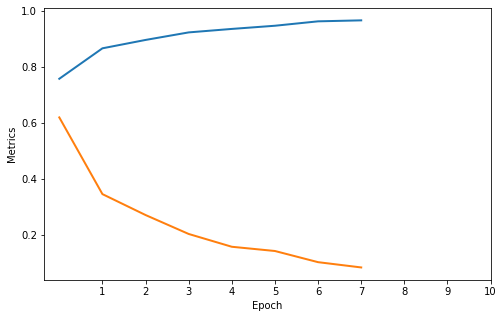

In [141]:

plt.figure(figsize=(8,5))
plt.plot(history.history['sparse_categorical_accuracy'], linewidth = 2)
plt.plot(history.history['loss'], linewidth = 2)
plt.xticks([x for x in range(1, epochs+1)])
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.show()
plt.close()


# Classification report

In [138]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

# test prediction of trained model
predictions = model.predict(test_data)

# classification report
print(classification_report(test_int_labels, numpy.argmax(predictions, axis=1)))

41/41 [==============================] - 54s 1s/step
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       300
           1       0.81      0.89      0.85       306
           2       0.96      0.99      0.98       405
           3       0.97      0.94      0.95       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



Confusion Matrix:
[[249  45   4   2]
 [ 15 273  11   7]
 [  2   2 401   0]
 [  2  15   1 282]]


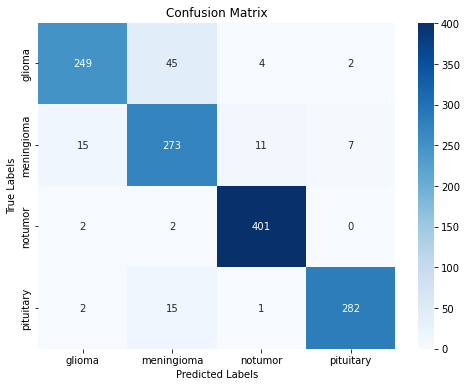

Confusion Matrix:
[[249  45   4   2]
 [ 15 273  11   7]
 [  2   2 401   0]
 [  2  15   1 282]]


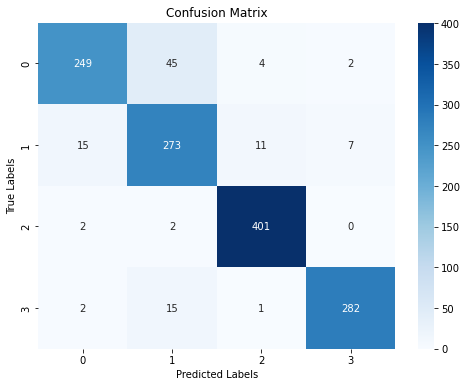

In [148]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_int_labels, numpy.argmax(predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
#sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
plt.close()

# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_int_labels, numpy.argmax(predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
#sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
plt.close()

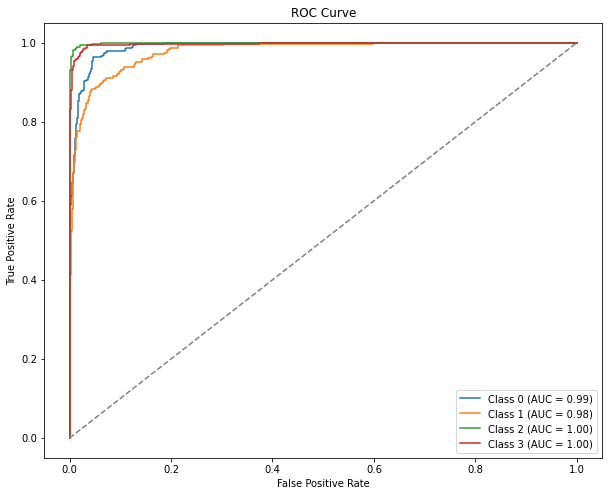

In [149]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_int_labels, classes=numpy.arange(len(os.listdir(train_dir))))
test_predictions_bin = predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [150]:
# Save the entire model
model.save('model.h5')

In [151]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

In [ ]:
import numpy as np

# Class labels
class_labels = ['glioma','meningioma','notumor','pituitary']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 [==============================] - 0s 115ms/step


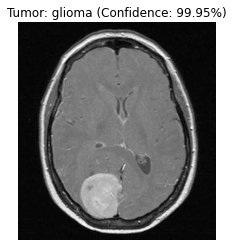

In [163]:
# Example usage
image_path = r'C:\Users\_Kamat_\Desktop\RPI\LLM_course\BrainTumorDetection_VGG_classifier\Data\Testing\meningioma\Te-me_0010.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 [==============================] - 0s 110ms/step


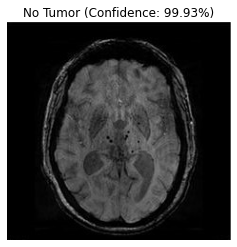

In [166]:
# Example usage
image_path = r'C:\Users\_Kamat_\Desktop\RPI\LLM_course\BrainTumorDetection_VGG_classifier\Data\Testing\notumor\Te-no_0060.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)